In [2]:
from keras.applications.vgg16 import VGG16
from PIL import Image
import numpy as np
from keras.models import Model
from keras import backend as K

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


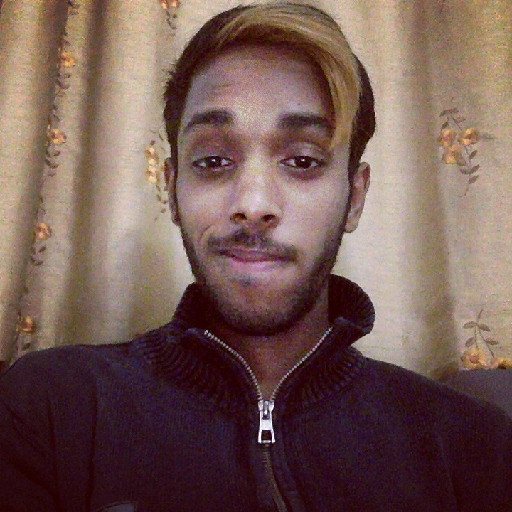

In [3]:
content = Image.open('me.jpg')
content = content.resize((512, 512))
content

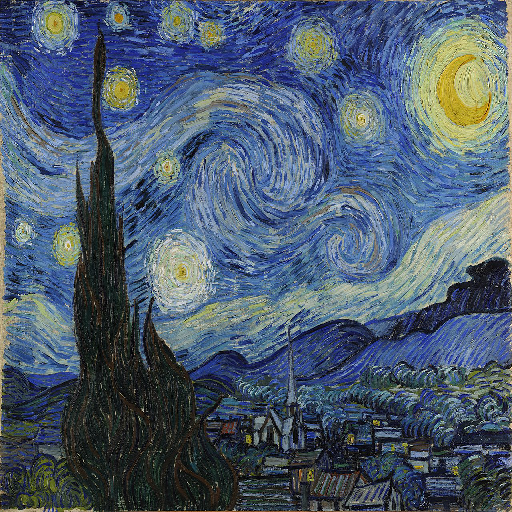

In [4]:
style = Image.open('style.jpg')
style = style.resize((512, 512))
style

In [5]:
height, width, channels = 512, 512, 3

In [6]:
content_array = np.asarray(content, dtype='float32')
content_array = content_array[np.newaxis, :, :, :]

style_array = np.asarray(style, dtype='float32')
style_array = style_array[np.newaxis, :, :, :]
style_array.shape

(1, 512, 512, 3)

In [7]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [8]:
content_image = K.variable(content_array)
style_image = K.variable(style_array)

result_image = K.placeholder((1, height, width, channels))
input_tensor = K.concatenate([content_image, style_image,result_image], axis=0)

In [9]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [13]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [14]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [17]:
def content_loss(content, result):
    return K.sum(K.square(result - content))

layer_features = layers['block2_conv2']
content_features = layer_features[0, :, :, :]
result_features = layer_features[2, :, :, :]

loss = K.variable(0.)

loss += content_weight * content_loss(content_features,  result_features)

In [18]:
def get_gram(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [19]:
def style_loss(style, result):
    Style = get_gram(style)
    Result = get_gram(result)
    
    size = height * width
    return K.sum(K.square(Style - Result)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [22]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(result_image)

In [23]:
gradients = K.gradients(loss, result_image)
outputs = [loss]
outputs += gradients
f_outputs = K.function([result_image], outputs)

In [38]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Sri(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

sri = Sri()

In [39]:
from scipy.optimize import fmin_l_bfgs_b

x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

epochs = 10

for i in range(epochs):
    print('Start of iteration', i)
    x, min_val, info = fmin_l_bfgs_b(sri.loss, x.flatten(), fprime=sri.grads, maxfun=20)
    print('Current loss value:', min_val)

Start of iteration 0
Current loss value: 59584668000.0
Start of iteration 1
Current loss value: 35982870000.0
Start of iteration 2
Current loss value: 29412342000.0
Start of iteration 3
Current loss value: 27201425000.0
Start of iteration 4
Current loss value: 26099382000.0
Start of iteration 5
Current loss value: 25476803000.0
Start of iteration 6
Current loss value: 25123170000.0
Start of iteration 7
Current loss value: 24909343000.0
Start of iteration 8
Current loss value: 24724322000.0
Start of iteration 9
Current loss value: 24595986000.0


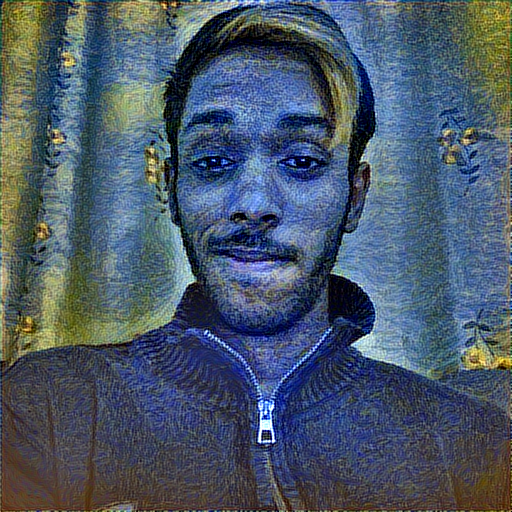

In [40]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)